# Feature Engineering

* Using Open Source Libraries.

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import holoviews as hv
from holoviews import opts

sns.set()


# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.discretisation import EqualFrequencyDiscretiser

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper


# Built-in library
import itertools
import re
import json
from typing import List, Union, Dict, Tuple

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# Helper Function(s)
def load_data(
    *,
    filepath: str,
    format_: str = "csv",
    sheet_name: Union[str, int, None] = 0,
    delimiter: Union[str, None] = None,
    low_memory: bool = True,
) -> pd.DataFrame:
    """This is used to load csv or excel data.

    Params:
    -------
    filepath: str
        The filepath to the input data.
    format_: str, default=csv
        The format of the input data. It can be 'csv' or 'excel'.
    sheet_name: Union[str, int, None], default=0
        The name of the excel sheet.
    delimiter: Union[str, None] default=None
        Delimiter to use. If sep is None, the C engine cannot automatically detect
    the separator, but the Python parsing engine can, meaning the latter will
    be used and automatically detect the separator by Python's builtin sniffer tool
    low_memory : bool, default=True
        Internally process the file in chunks, resulting in lower memory use
        while parsing, but possibly mixed type inference.  To ensure no mixed
        types either set False, or specify the type with the `dtype` parameter.
        Note that the entire file is read into a single DataFrame regardless,
        use the `chunksize` or `iterator` parameter to return the data in chunks.
        (Only valid with C parser).

    Returns:
    --------
    data: Pandas DF
        A DF containing the loaded input data.
    """
    data = (
        pd.read_csv(
            filepath_or_buffer=filepath, delimiter=delimiter, low_memory=low_memory
        )
        if format_ == "csv"
        else pd.read_excel(io=filepath, sheet_name=sheet_name)  # if format_ == 'excel'
    )
    data.columns = data.columns.str.strip()
    print(f"The shape of the data: {data.shape}\n")
    return data

In [3]:
# Data description
fp = "../data/LCDataDictionary.xlsx"
data_desc = load_data(filepath=fp, format_="excel")
data_desc = data_desc.sort_values("LoanStatNew")
data_desc

The shape of the data: (80, 2)



/Users/neidu/miniconda3/envs/ds/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


LoanStatNew  \
75               acc_now_delinq   
0                    addr_state   
70                     all_util   
1                    annual_inc   
2              annual_inc_joint   
3              application_type   
4       collection_recovery_fee   
5    collections_12_mths_ex_med   
6                   delinq_2yrs   
7                          desc   
8                           dti   
9                     dti_joint   
10             earliest_cr_line   
11                   emp_length   
12                    emp_title   
13              fico_range_high   
14               fico_range_low   
15                  funded_amnt   
16              funded_amnt_inv   
17                        grade   
18               home_ownership   
19                           id   
66                      il_util   
20          initial_list_status   
72                       inq_fi   
74                 inq_last_12m   
21               inq_last_6mths   
22                  installment   
23                     int_rate   
24                     is_inc_v   
25                      issue_d   
26           last_credit_pull_d   
27         last_fico_range_high   
28          last_fico_range_low   
29              last_pymnt_amnt   
30                 last_pymnt_d   
31                    loan_amnt   
32                  loan_status   
69                   max_bal_bc   
33                    member_id   
34       mths_since_last_delinq   
35  mths_since_last_major_derog   
36       mths_since_last_record   
64           mths_since_rcnt_il   
37                 next_pymnt_d   
38                     open_acc   
60                  open_acc_6m   
62                  open_il_12m   
63                  open_il_24m   
61                   open_il_6m   
67                  open_rv_12m   
68                  open_rv_24m   
39                    out_prncp   
40                out_prncp_inv   
41                  policy_code   
42                      pub_rec   
43                      purpose   
44                   pymnt_plan   
45                   recoveries   
46                    revol_bal   
47                   revol_util   
48                    sub_grade   
49                         term   
50                        title   
76                 tot_coll_amt   
77                  tot_cur_bal   
51                    total_acc   
65                 total_bal_il   
73                  total_cu_tl   
52                  total_pymnt   
53              total_pymnt_inv   
54                total_rec_int   
55           total_rec_late_fee   
56              total_rec_prncp   
71           total_rev_hi_lim     
57                          url   
58        verified_status_joint   
59                     zip_code   
78                          NaN   
79                          NaN   

                                                                                                                                                                                                           Description  
75                                                                                                                                                     The number of accounts on which the borrower is now delinquent.  
0                                                                                                                                                           The state provided by the borrower in the loan application  
70                                                                                                                                                                               Balance to credit limit on all trades  
1                                                                                                                                        The self-reported annual income provided by the borrower during registration.  
2                                                                                                  

In [4]:
fp = "../data/lc_2016_2017.csv"  # Filepath
columns_to_drop = ["id", "member_id", "desc", "policy_code"]

orig_data = load_data(filepath=fp, format_="csv", low_memory=False)
orig_data.drop(columns=columns_to_drop, inplace=True)

orig_data.head(10)

The shape of the data: (759338, 72)



loan_amnt  funded_amnt  funded_amnt_inv       term  int_rate  installment  \
0       2300         2300           2300.0  36 months     12.62        77.08   
1      16000        16000          16000.0  60 months     12.62       360.95   
2       6025         6025           6025.0  36 months     15.05       209.01   
3      20400        20400          20400.0  36 months      9.44       652.91   
4      13000        13000          13000.0  36 months     11.99       431.73   
5      12000        12000          12000.0  36 months      9.44       384.06   
6       6000         6000           6000.0  36 months     10.42       194.79   
7      12000        12000          12000.0  60 months     15.05       285.80   
8      11575        11575          11575.0  36 months      7.35       359.26   
9      20400        20400          20400.0  60 months      7.97       413.35   

  grade sub_grade            emp_title emp_length home_ownership  annual_inc  \
0     C        C1                  NaN        NaN            OWN    10000.00   
1     C        C1              teacher  10+ years       MORTGAGE    94000.00   
2     C        C4         Front Office    7 years       MORTGAGE    46350.00   
3     B        B1              Manager  10+ years           RENT    44000.00   
4     B        B5            Paramedic  10+ years       MORTGAGE    85000.00   
5     B        B1              Teacher  10+ years       MORTGAGE    70000.00   
6     B        B3         Office Clerk    7 years       MORTGAGE    37107.19   
7     C        C4     PROGRAM DIRECTOR    6 years           RENT    69800.00   
8     A        A4  Solutions Architect    6 years            OWN   153000.00   
9     A        A5   asst plant manager  10+ years       MORTGAGE   110000.00   

  verification_status   issue_d loan_status pymnt_plan             purpose  \
0        Not Verified  Jun-2017     Current          n         credit_card   
1        Not Verified  Jun-2017     Current          n  debt_consolidation   
2        Not Verified  Jun-2017     Current          n    home_improvement   
3     Source Verified  Jun-2017     Current          n                 car   
4     Source Verified  Jun-2017     Current          n  debt_consolidation   
5        Not Verified  Jun-2017     Current          n  debt_consolidation   
6     Source Verified  Jun-2017     Current          n             medical   
7        Not Verified  Jun-2017     Current          n  debt_consolidation   
8        Not Verified  Jun-2017  Fully Paid          n         credit_card   
9        Not Verified  Jun-2017     Current          n      major_purchase   

                     title zip_code addr_state    dti  delinq_2yrs  \
0  Credit card refinancing    148xx         NY  21.61            0   
1       Debt consolidation    021xx         MA  25.61            0   
2         Home improvement    018xx         MA   8.88            0   
3            Car financing    913xx         CA  27.06            0   
4       Debt consolidation    560xx         MN   6.79            1   
5       Debt consolidation    184xx         PA  18.34            0   
6         Medical expenses    773xx         TX  30.63            0   
7       Debt consolidation    953xx         CA  31.43            0   
8  Credit card refinancing    923xx         CA  16.99            0   
9           Major purchase    286xx         NC  11.07            0   

  earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
0         Sep-1985             1.0                     NaN   
1         Jun-1992             0.0                     NaN   
2         Jun-2002             0.0                     NaN   
3         Jan-2007             1.0                     NaN   
4         Feb-2002             0.0                    16.0   
5         Aug-1997             0.0                    35.0   
6         Mar-1992             0.0                    70.0   
7         Feb-2006             1.0                     NaN   
8         Jul-1994             0.0                   

In [5]:
# These labels will be treated as default
default_list = [
    "Charged Off",
    "Late (31-120 days)",
    "Default",
    "Does not meet the credit policy. Status:Charged Off",
]

# Update the loan_status
orig_data["loan_status"] = orig_data["loan_status"].apply(
    lambda status: 1 if status in default_list else 0
)

# Check the frequency table of the target
orig_data["loan_status"].value_counts(normalize=True)

0    0.930746
1    0.069254
Name: loan_status, dtype: float64

### Drop Variables

* I'll drop a few variables based on my exploration from the EDA notebook. 

In [6]:
num_vars_to_drop = [
    "funded_amnt",
    "funded_amnt_inv",
    "installment",
    "total_pymnt_inv",
    "total_rec_prncp",
    "out_prncp_inv",
    "collection_recovery_fee",
    "open_rv_24m",
    "dti_joint",
    "annual_inc_joint",
    "mths_since_last_record",
]

cat_vars_to_drop = [
    "emp_title",
    "issue_d",
    "last_pymnt_d",
    "next_pymnt_d",
    "last_credit_pull_d",
    "sub_grade",
    "title",
    "earliest_cr_line",
    "pymnt_plan",
    "verification_status_joint",
]

# Drop the variables
orig_data.drop(columns=num_vars_to_drop + cat_vars_to_drop, inplace=True)

# Split dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the **`train`** set. This is to avoid over-fitting.

Our feature engineering techniques will learn:

* mean
* median
* mode
* exponents for the yeo-johnson
* category frequency
* and category to number mappings

from the train set.

**Separating the data into train and test involves randomness, therefore, we need to set the seed.**

In [7]:
target = "loan_status"
X = orig_data.drop(columns=[target])
y = orig_data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123
)

### Handle Missing Data

#### Categorical Data

1. I'll replace missing values with the string ***"missing"*** in those variables with a lot of missing data.
2. I'll replace the NaNs with the most occurring variables in those variables that contain fewer observations with NaN values.

In [8]:
numerical_variables = [
    col
    for col in orig_data.columns
    if orig_data[col].dtype != "O" and col != "loan_status"
]

categorical_variables = [
    col
    for col in orig_data.columns
    if orig_data[col].dtype == "O" and col != "loan_status"
]

# Check the number of numerical and categorical variables
len(numerical_variables), len(categorical_variables)

(36, 10)

In [9]:
print(
    f"Numerical Variables: {numerical_variables}  \n\nCategorical Variables: {categorical_variables}"
)

Numerical Variables: ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m']  

Categorical Variables: ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'zip_code', 'addr_state', 'initial_list_status', 'application_type']


In [10]:
# List containing missing categorical data
THRESH = 0

cat_vars_with_na = [
    col for col in categorical_variables if X_train[col].isna().sum() > THRESH
]

X_train[cat_vars_with_na].isna().mean().sort_values(ascending=False)

emp_length    0.066358
zip_code      0.000001
dtype: float64

In [11]:
# Variables to impute with the string 'missing'
MISSING_THRESH = 0.30
repl_with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() > MISSING_THRESH
]

# Variables to impute with the most frequent label
repl_with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() < MISSING_THRESH
]

repl_with_string_missing, repl_with_frequent_category

([], ['emp_length', 'zip_code'])

In [12]:
# Replace missing values with most frequent category

# Instantiate an object using the class
cat_imputer_frequent = CategoricalImputer(
    imputation_method="frequent", variables=repl_with_frequent_category
)

# Fit
cat_imputer_frequent.fit(X_train)

# The class learns and stores the parameters
cat_imputer_frequent.imputer_dict_

{'emp_length': '10+ years', 'zip_code': '750xx'}

In [13]:
# Replace NaN by missing in the Train and Test data

# Note that this can be stored with joblib
X_train = cat_imputer_frequent.transform(X_train)
X_test = cat_imputer_frequent.transform(X_test)

In [14]:
# Verify that there are no NaNs (Train)
X_train[cat_vars_with_na].isna().mean().sort_values(ascending=False)

emp_length    0.0
zip_code      0.0
dtype: float64

In [15]:
# Verify that there are no NaNs (Test)
X_test[cat_vars_with_na].isna().mean().sort_values(ascending=False)

emp_length    0.0
zip_code      0.0
dtype: float64

#### Numerical Data

1. I'll create a missing indicator flag (a new variable) for the missing values.
2. Finally, I'll replace the missing values with the mean or median value (if the distibution of the variable is skewed).

In [16]:
X_train[numerical_variables].isna().mean().sort_values(ascending=False)

mths_since_last_major_derog    0.716389
mths_since_last_delinq         0.477434
il_util                        0.132411
mths_since_rcnt_il             0.027022
revol_util                     0.000679
dti                            0.000468
all_util                       0.000151
total_cu_tl                    0.000079
open_acc_6m                    0.000079
inq_last_12m                   0.000079
inq_fi                         0.000078
max_bal_bc                     0.000078
open_rv_12m                    0.000078
total_bal_il                   0.000078
open_il_24m                    0.000078
open_il_12m                    0.000078
inq_last_6mths                 0.000001
total_rev_hi_lim               0.000000
tot_coll_amt                   0.000000
tot_cur_bal                    0.000000
loan_amnt                      0.000000
acc_now_delinq                 0.000000
int_rate                       0.000000
last_pymnt_amnt                0.000000
recoveries                     0.000000


In [17]:
# Variables to impute with the string 'mean' or 'median'
THRESH = 0
num_vars_with_na = [
    var for var in numerical_variables if X_train[var].isnull().mean() > THRESH
]


num_vars_with_na

['dti',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'revol_util',
 'mths_since_last_major_derog',
 'open_acc_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [18]:
# Add missing indicator
missing_indicator = AddMissingIndicator(variables=num_vars_with_na)
# Fit and transform does not work (surprisingly)
missing_indicator.fit(X_train)

# Replace NaN by missing in the Test data
X_train = missing_indicator.transform(X_train)
X_test = missing_indicator.transform(X_test)

In [19]:
# check the binary missing indicator variables
na_cols = [var for var in X_train.columns if "_na" in var]
X_train[na_cols].head()

dti_na  inq_last_6mths_na  mths_since_last_delinq_na  revol_util_na  \
429621       0                  0                          0              0   
620328       0                  0                          1              0   
562165       0                  0                          0              0   
580583       0                  0                          1              0   
645607       0                  0                          1              0   

        mths_since_last_major_derog_na  open_acc_6m_na  open_il_12m_na  \
429621                               0               0               0   
620328                               1               0               0   
562165                               1               0               0   
580583                               1               0               0   
645607                               1               0               0   

        open_il_24m_na  mths_since_rcnt_il_na  total_bal_il_na  il_util_na  \
429621               0                      0                0           0   
620328               0                      0                0           0   
562165               0                      0                0           0   
580583               0                      0                0           0   
645607               0                      0                0           0   

        open_rv_12m_na  max_bal_bc_na  all_util_na  inq_fi_na  total_cu_tl_na  \
429621               0              0            0          0               0   
620328               0              0            0          0               0   
562165               0              0            0          0               0   
580583               0              0            0          0               0   
645607               0              0            0          0               0   

        inq_last_12m_na  
429621                0  
620328                0  
562165                0  
580583                0  
645607                0

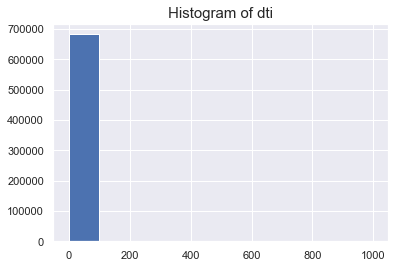

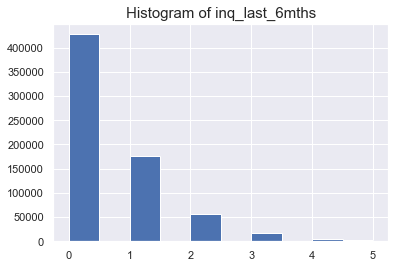

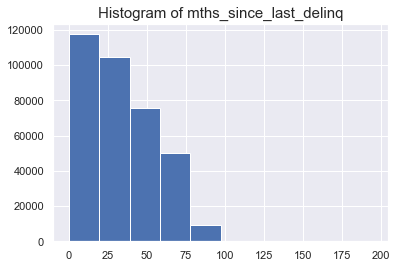

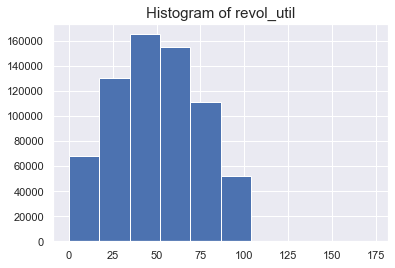

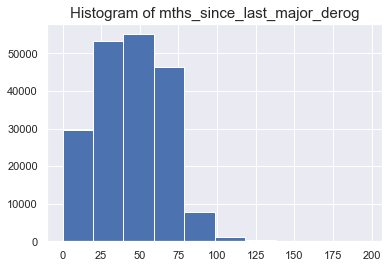

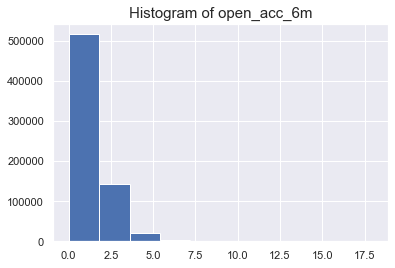

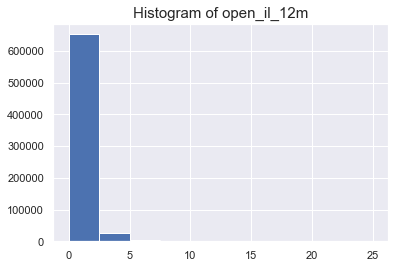

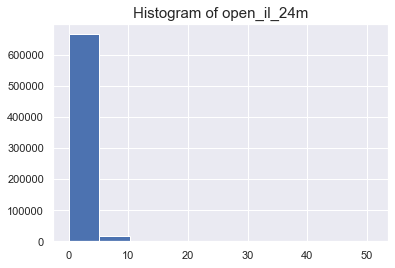

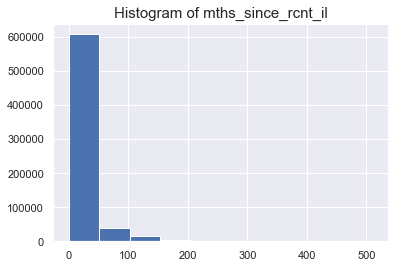

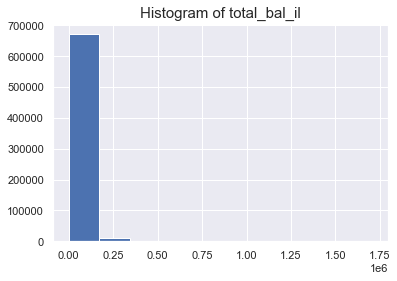

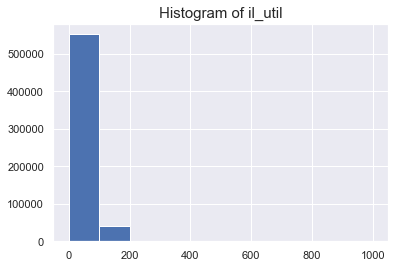

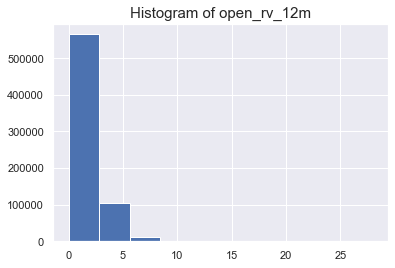

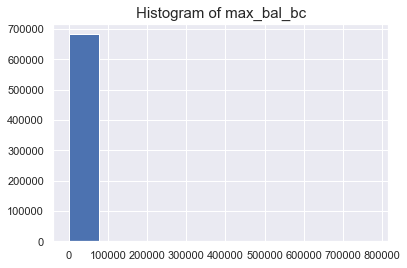

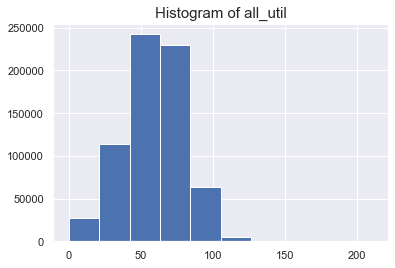

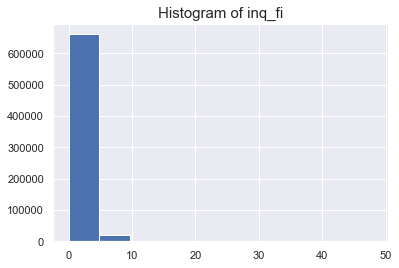

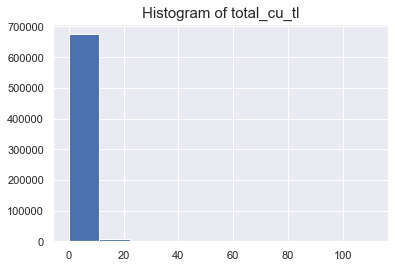

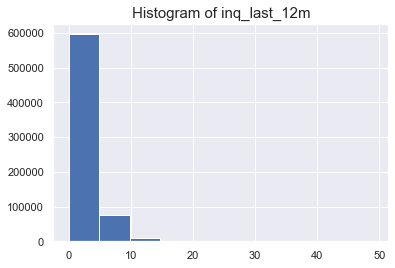

In [20]:
# Histogram of Transformed variables
for var in num_vars_with_na:
    try:
        plt.hist(x=var, data=X_train)
        plt.title(f"Histogram of {var}", size=15)
        plt.show()
    except Exception as err:
        print(f"{var}: {err}")

In [21]:
repl_vars_with_median = [
    "dti",
    "inq_last_6mths",
    "mths_since_last_delinq",
    "mths_since_last_major_derog",
    "all_util",
]
repl_vars_with_mean = [
    "revol_util",
    "open_acc_6m",
    "open_il_12m",
    "open_il_24m",
    "mths_since_rcnt_il",
    "total_bal_il",
    "il_util",
    "open_rv_12m",
    "max_bal_bc",
    "inq_fi",
    "total_cu_tl",
    "inq_last_12m",
]
# Replace missing data with the mean

# Set the Median imputer
median_imputer = MeanMedianImputer(
    imputation_method="median", variables=repl_vars_with_median
)

# Set the Mean imputer
mean_imputer = MeanMedianImputer(
    imputation_method="mean", variables=repl_vars_with_mean
)

# Fit
median_imputer.fit(X_train)
mean_imputer.fit(X_train)

# The learned parameters
median_imputer.imputer_dict_, mean_imputer.imputer_dict_

({'dti': 18.18,
  'inq_last_6mths': 0.0,
  'mths_since_last_delinq': 30.0,
  'mths_since_last_major_derog': 44.0,
  'all_util': 60.0},
 {'revol_util': 49.95912832752579,
  'open_acc_6m': 0.9547230555352308,
  'open_il_12m': 0.6801936340182425,
  'open_il_24m': 1.586821413885397,
  'mths_since_rcnt_il': 21.315020821521436,
  'total_bal_il': 35742.84424549024,
  'il_util': 70.02927574656695,
  'open_rv_12m': 1.3397170707293908,
  'max_bal_bc': 5791.014017686372,
  'inq_fi': 0.9689632414381482,
  'total_cu_tl': 1.4755688885636935,
  'inq_last_12m': 2.1088827101778005})

In [22]:
# Impute the NaNs
# Median
X_train = median_imputer.transform(X_train)
X_test = median_imputer.transform(X_test)

# Mean
X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)

In [23]:
# Verify
X_train[num_vars_with_na].isna().mean().sort_values(ascending=False)

dti                            0.0
total_bal_il                   0.0
total_cu_tl                    0.0
inq_fi                         0.0
all_util                       0.0
max_bal_bc                     0.0
open_rv_12m                    0.0
il_util                        0.0
mths_since_rcnt_il             0.0
inq_last_6mths                 0.0
open_il_24m                    0.0
open_il_12m                    0.0
open_acc_6m                    0.0
mths_since_last_major_derog    0.0
revol_util                     0.0
mths_since_last_delinq         0.0
inq_last_12m                   0.0
dtype: float64

In [24]:
# Verify
X_test[num_vars_with_na].isna().mean().sort_values(ascending=False)

dti                            0.0
total_bal_il                   0.0
total_cu_tl                    0.0
inq_fi                         0.0
all_util                       0.0
max_bal_bc                     0.0
open_rv_12m                    0.0
il_util                        0.0
mths_since_rcnt_il             0.0
inq_last_6mths                 0.0
open_il_24m                    0.0
open_il_12m                    0.0
open_acc_6m                    0.0
mths_since_last_major_derog    0.0
revol_util                     0.0
mths_since_last_delinq         0.0
inq_last_12m                   0.0
dtype: float64

### Discrete Variables

In [25]:
UNIQUE_THRESH = 20

discr_vars = [
    var
    for var in X_train[numerical_variables]
    if X_train[var].nunique() <= UNIQUE_THRESH
]
continuous_vars = [
    var
    for var in X_train[numerical_variables]
    if X_train[var].nunique() > UNIQUE_THRESH
]


print(f"Discrete Variables: {discr_vars}  \n\nContinuous Variables: {continuous_vars}")

Discrete Variables: ['inq_last_6mths', 'collections_12_mths_ex_med', 'acc_now_delinq', 'open_acc_6m', 'open_il_12m']  

Continuous Variables: ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m']


In [26]:
# Cast to Objects
X_train[discr_vars] = X_train[discr_vars].astype("O")
X_test[discr_vars] = X_test[discr_vars].astype("O")

### Numerical Variables transformation

* In the EDA notebook, log transformation was applied to the some variables.

<hr>

Select the min values. Min values with 0 can't be log-transformed

In [27]:
temp = X_train[continuous_vars]
result_dict = temp.describe(percentiles=[0, 0.5, 1]).to_dict()

# Select the min values. Min values with 0 can't be log-transformed
result = {
    key: val.get("min") for key, val in result_dict.items() if "min" in val.keys()
}
result

{'loan_amnt': 1000.0,
 'int_rate': 5.32,
 'annual_inc': 0.0,
 'dti': -1.0,
 'delinq_2yrs': 0.0,
 'mths_since_last_delinq': 0.0,
 'open_acc': 0.0,
 'pub_rec': 0.0,
 'revol_bal': 0.0,
 'revol_util': 0.0,
 'total_acc': 2.0,
 'out_prncp': 0.0,
 'total_pymnt': 0.0,
 'total_rec_int': 0.0,
 'total_rec_late_fee': -1.36e-08,
 'recoveries': 0.0,
 'last_pymnt_amnt': 0.0,
 'mths_since_last_major_derog': 0.0,
 'tot_coll_amt': 0.0,
 'tot_cur_bal': 0.0,
 'open_il_24m': 0.0,
 'mths_since_rcnt_il': 0.0,
 'total_bal_il': 0.0,
 'il_util': 0.0,
 'open_rv_12m': 0.0,
 'max_bal_bc': 0.0,
 'all_util': 0.0,
 'total_rev_hi_lim': 0.0,
 'inq_fi': 0.0,
 'total_cu_tl': 0.0,
 'inq_last_12m': 0.0}

In [28]:
# Variables that have zeros
zero_values = [key for key, val in result.items() if val == 0]
zero_values

['annual_inc',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'out_prncp',
 'total_pymnt',
 'total_rec_int',
 'recoveries',
 'last_pymnt_amnt',
 'mths_since_last_major_derog',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

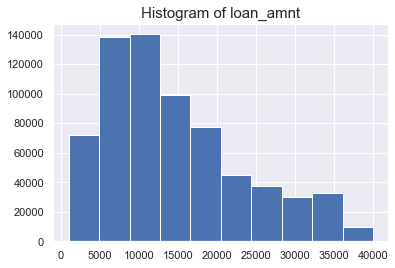

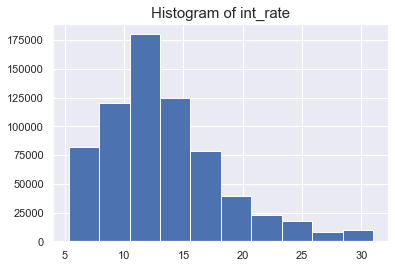

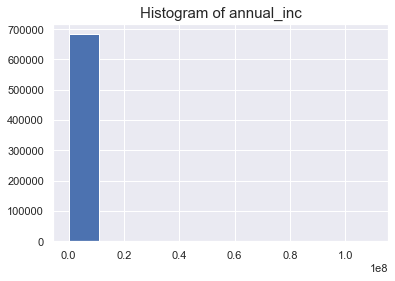

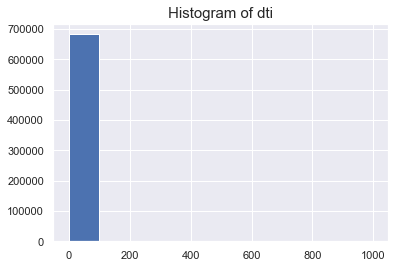

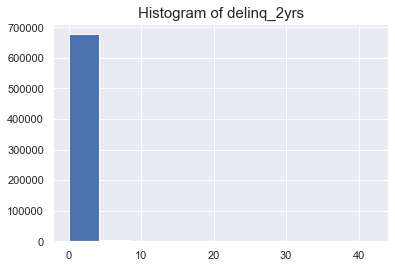

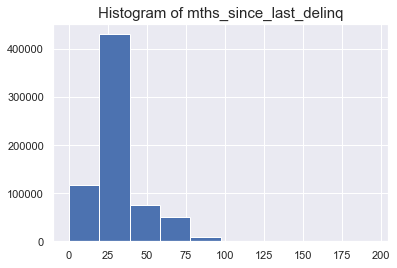

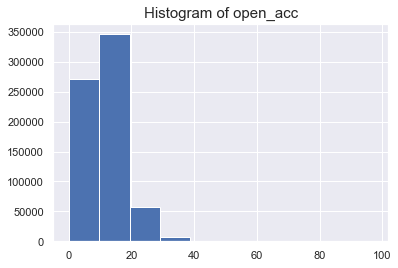

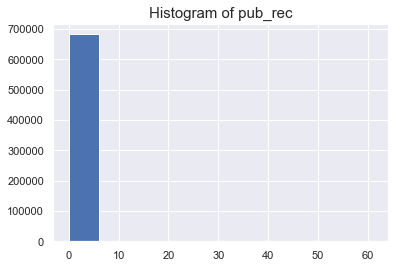

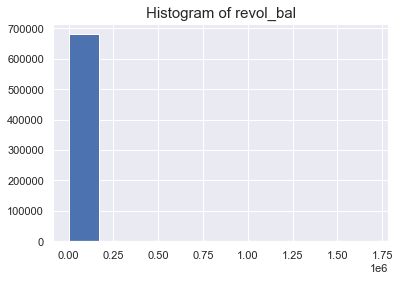

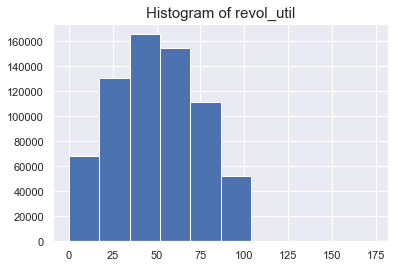

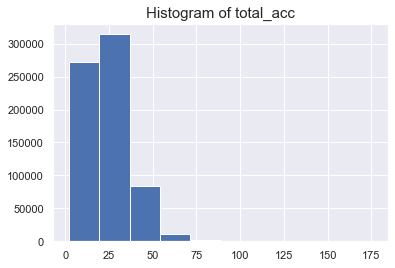

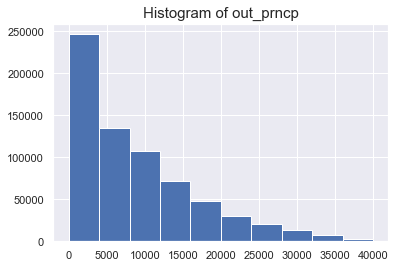

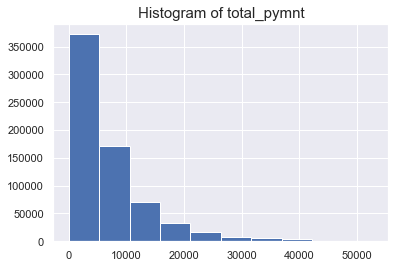

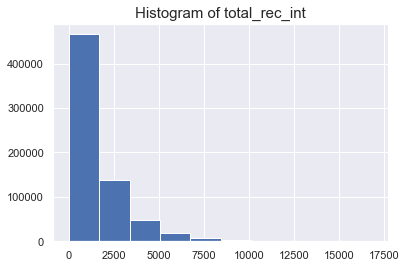

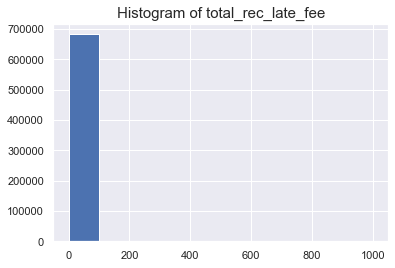

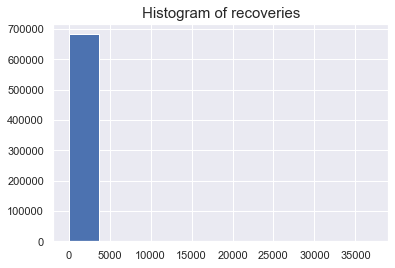

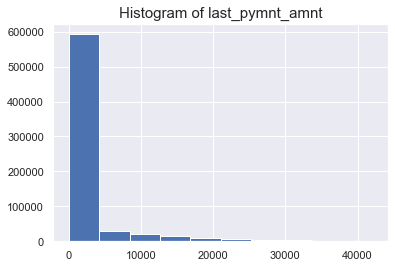

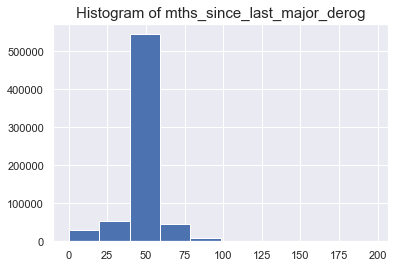

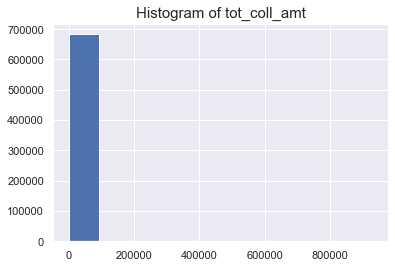

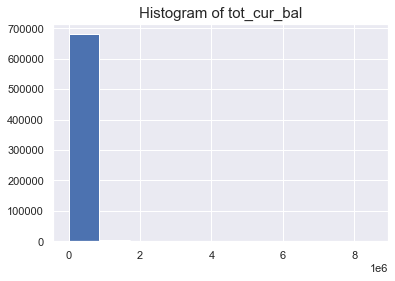

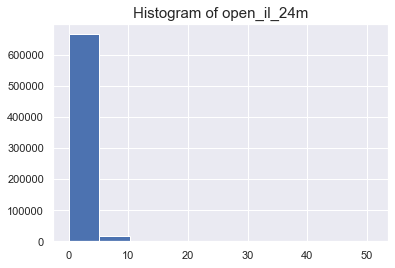

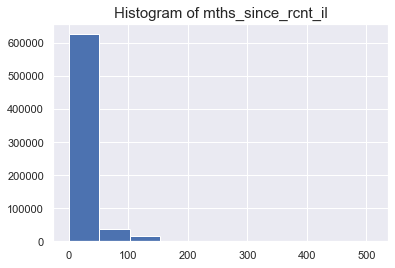

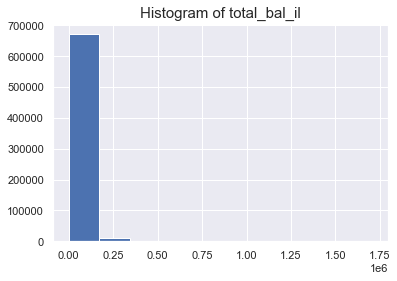

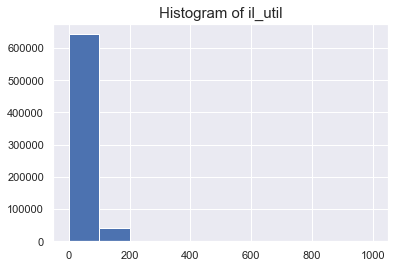

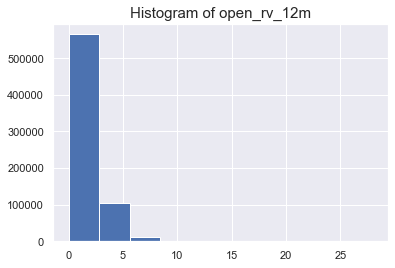

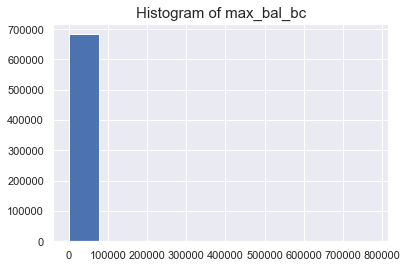

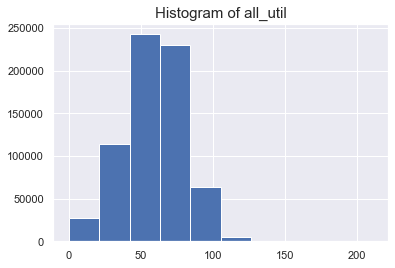

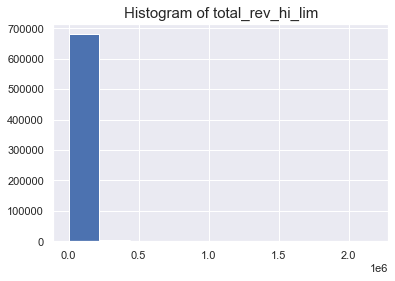

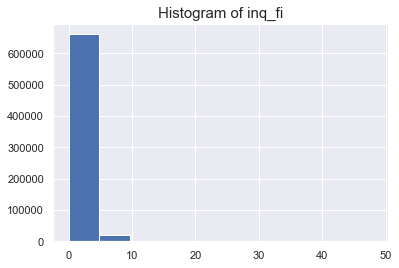

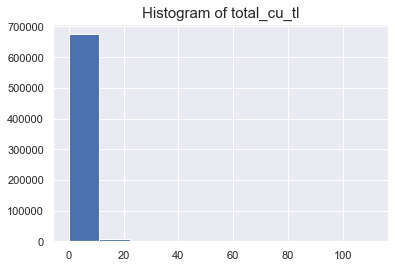

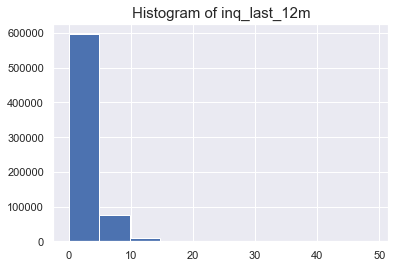

In [29]:
# Histogram of Transformed variables
for var in continuous_vars:
    try:
        plt.hist(x=var, data=X_train)
        plt.title(f"Histogram of {var}", size=15)
        plt.show()
    except Exception as err:
        print(f"{var}: {err}")

In [30]:
vars_to_transform = [
    "il_util",
    "int_rate",
    "last_pymnt_amnt",
    "max_bal_bc",
    "mths_since_last_delinq",
    "mths_since_last_major_derog",
    "mths_since_rcnt_il",
    "open_acc",
    "revol_bal",
    "tot_cur_bal",
    "total_acc",
    "total_bal_il",
    "total_pymnt",
    "total_rec_int",
    "total_rev_hi_lim",
]

vars_to_log_trans = list(set(vars_to_transform).difference(set(zero_values)))
faily_normal_vars = ["all_util", "loan_amnt", "revol_util"]
vars_to_yeo_trans = set(vars_to_transform).difference(
    set(faily_normal_vars).union(set(vars_to_log_trans))
)
vars_to_yeo_trans = list(vars_to_yeo_trans)
print(
    f"LogTransformed Variables: {vars_to_log_trans} \n\nYeoJohnson Transformed Variables: {vars_to_yeo_trans}"
)

LogTransformed Variables: ['total_acc', 'int_rate'] 

YeoJohnson Transformed Variables: ['max_bal_bc', 'last_pymnt_amnt', 'mths_since_last_delinq', 'revol_bal', 'il_util', 'total_rec_int', 'tot_cur_bal', 'total_bal_il', 'total_rev_hi_lim', 'mths_since_last_major_derog', 'mths_since_rcnt_il', 'open_acc', 'total_pymnt']


In [31]:
# Heavily skewed variables
var_to_bin = list(
    set(continuous_vars).difference(
        set(faily_normal_vars + vars_to_log_trans + vars_to_yeo_trans)
    )
)
var_to_bin

['dti',
 'open_rv_12m',
 'inq_fi',
 'open_il_24m',
 'out_prncp',
 'recoveries',
 'total_rec_late_fee',
 'total_cu_tl',
 'inq_last_12m',
 'delinq_2yrs',
 'pub_rec',
 'annual_inc',
 'tot_coll_amt']

In [32]:
log_transformer = LogTransformer(variables=vars_to_log_trans)
yeo_johnson_transformer = YeoJohnsonTransformer(variables=vars_to_yeo_trans)

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.transform(X_test)

X_train = yeo_johnson_transformer.fit_transform(X_train)
X_test = yeo_johnson_transformer.transform(X_test)

In [33]:
yeo_johnson_transformer.lambda_dict_

{'max_bal_bc': 0.3687257113156092,
 'last_pymnt_amnt': -0.14090965271958078,
 'mths_since_last_delinq': 0.5839426513799169,
 'revol_bal': 0.22326293988150614,
 'il_util': 1.206931360332099,
 'total_rec_int': 0.20648096624699475,
 'tot_cur_bal': 0.15339438690258525,
 'total_bal_il': 0.3156877637198364,
 'total_rev_hi_lim': 0.14702410563630758,
 'mths_since_last_major_derog': 0.9901186349502248,
 'mths_since_rcnt_il': -0.07224827150493668,
 'open_acc': 0.08095204028360206,
 'total_pymnt': 0.15274859103855237}

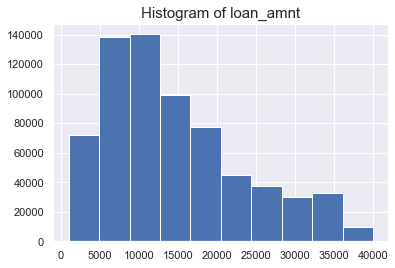

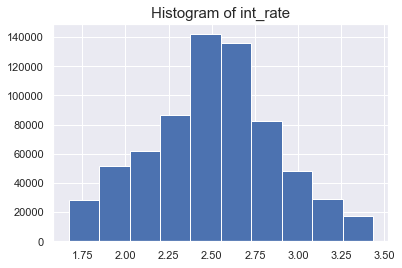

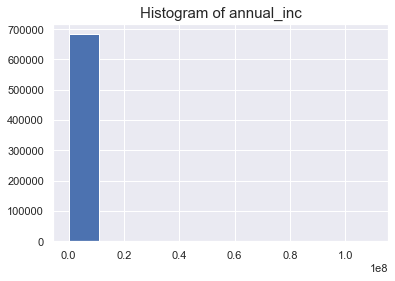

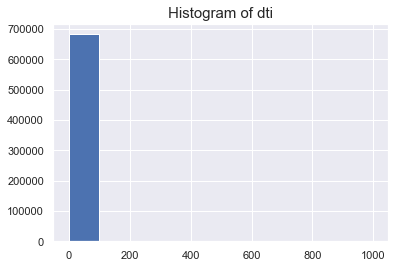

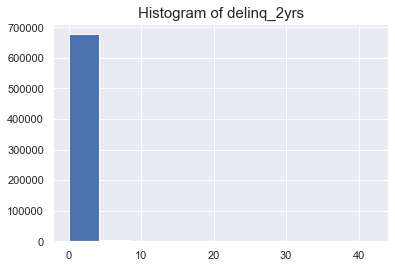

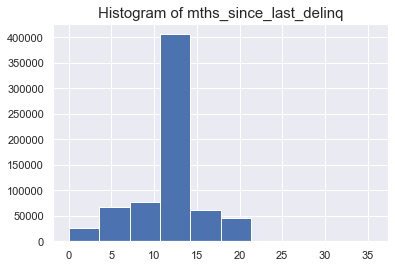

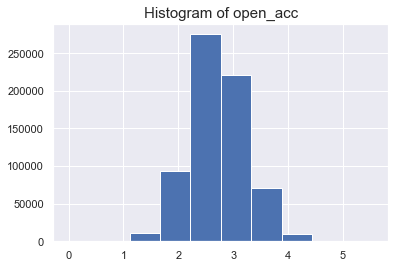

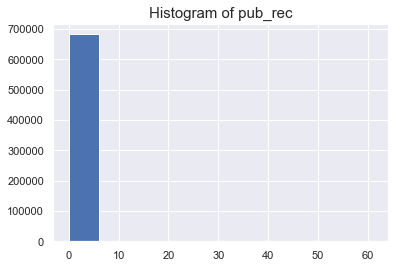

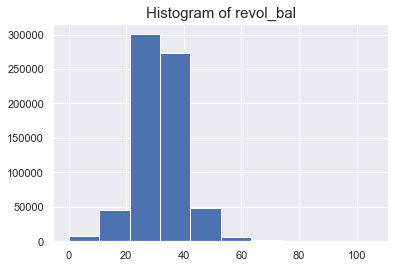

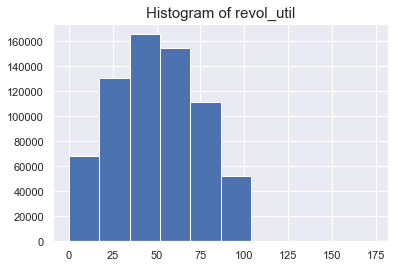

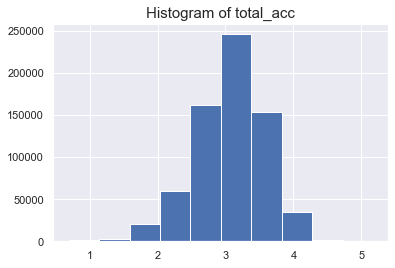

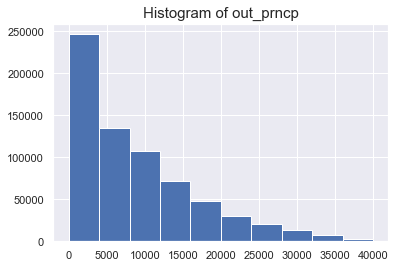

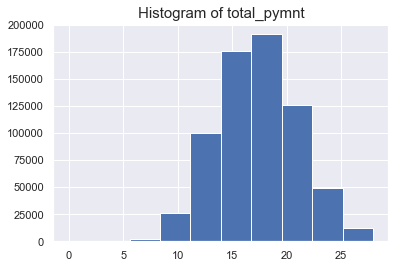

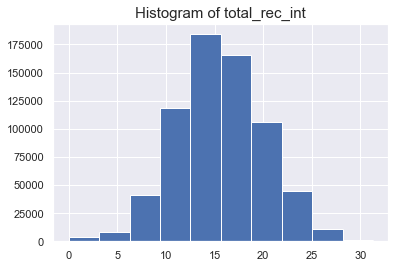

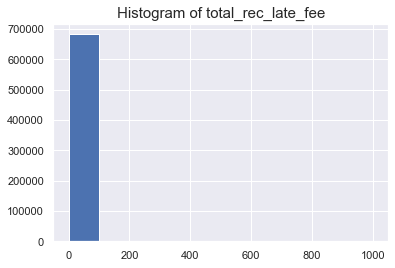

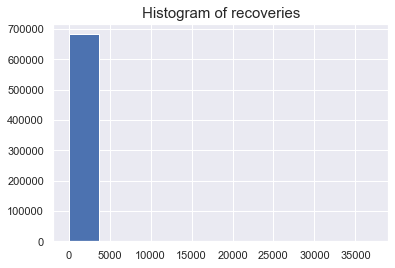

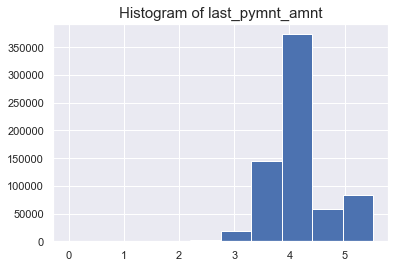

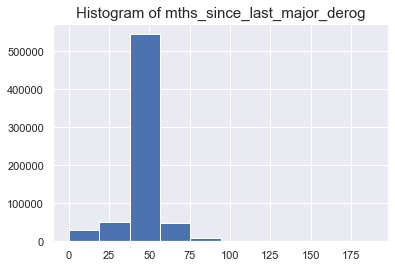

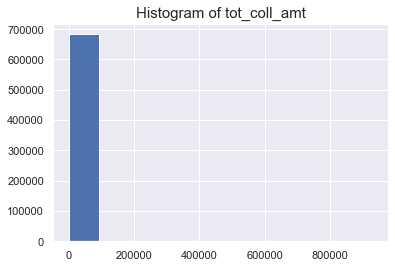

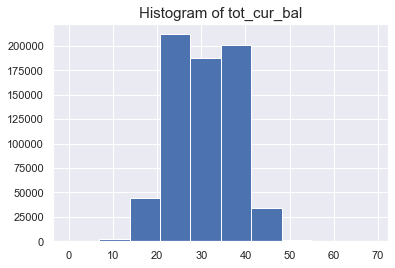

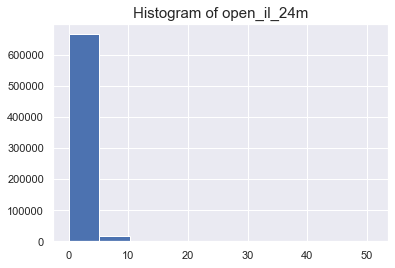

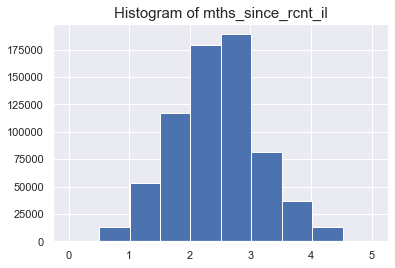

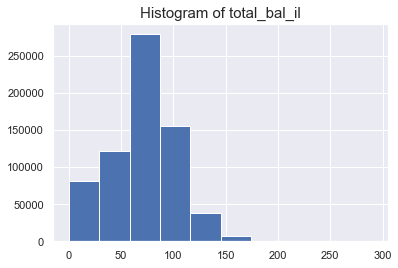

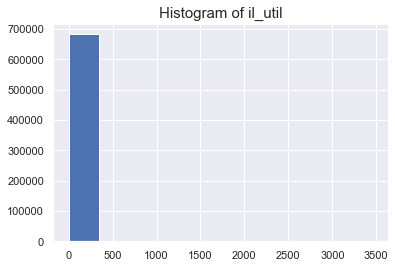

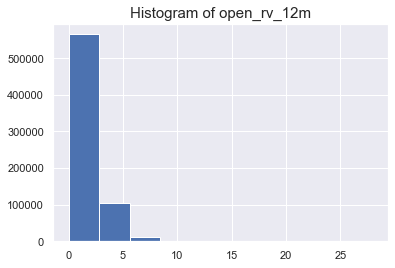

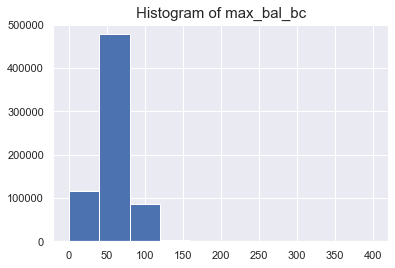

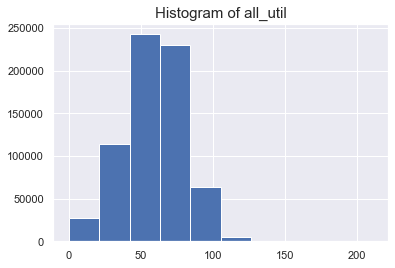

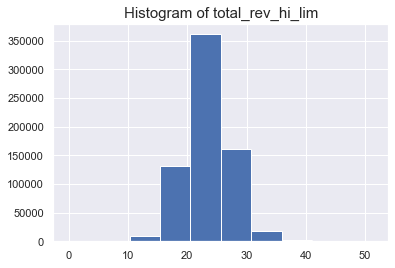

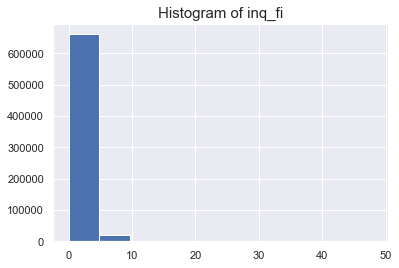

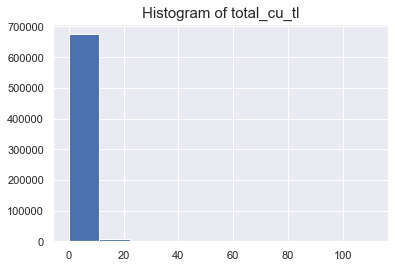

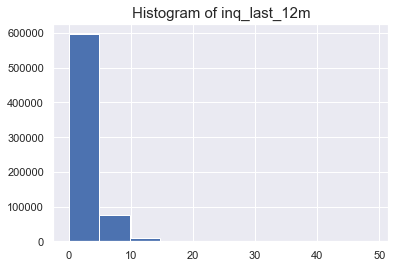

In [34]:
# Histogram of Transformed variables
for var in continuous_vars:
    try:
        plt.hist(x=var, data=X_train)
        plt.title(f"Histogram of {var}", size=15)
        plt.show()
    except Exception as err:
        print(f"{var}: {err}")

In [35]:
X_train[var_to_bin].nunique()

dti                     7245
open_rv_12m               30
inq_fi                    30
open_il_24m               32
out_prncp             219978
recoveries             13254
total_rec_late_fee      4273
total_cu_tl               61
inq_last_12m              42
delinq_2yrs               28
pub_rec                   32
annual_inc             39206
tot_coll_amt           10222
dtype: int64

In [36]:
discretiser = EqualFrequencyDiscretiser(variables=var_to_bin, q=10, return_object=True)
# Fit
X_train = discretiser.fit_transform(X_train)
# Apply to Test data
X_test = discretiser.transform(X_test)

In [37]:
# Verify
X_train[var_to_bin].nunique()

dti                   10
open_rv_12m            4
inq_fi                 4
open_il_24m            5
out_prncp              8
recoveries             1
total_rec_late_fee     2
total_cu_tl            4
inq_last_12m           5
delinq_2yrs            2
pub_rec                2
annual_inc            10
tot_coll_amt           2
dtype: int64

<br><hr>

### Categorical Variables

* Clean the 'emp_length' variable

In [38]:
X_train["emp_length"].value_counts()

10+ years    277464
2 years       62606
< 1 year      56478
3 years       54707
1 year        45487
5 years       41613
4 years       40984
6 years       29348
8 years       25801
9 years       25689
7 years       23227
Name: emp_length, dtype: int64

In [39]:
# Clean the emp_length
replace_dict = {
    "10+ years": "10",
    "2 years": "2",
    "< 1 year": "0",
    "3 years": "3",
    "1 year": "1",
    "5 years": "5",
    "4 years": "4",
    "6 years": "6",
    "8 years": "8",
    "9 years": "9",
    "7 years": "7",
}

# Apply the mapping
X_train["emp_length"] = X_train["emp_length"].replace(replace_dict)

X_train["emp_length"].value_counts()

10    277464
2      62606
0      56478
3      54707
1      45487
5      41613
4      40984
6      29348
8      25801
9      25689
7      23227
Name: emp_length, dtype: int64

#### Remove rare labels.

In [40]:
THRESH = 10
var_with_rare_labels = [
    var for var in categorical_variables + discr_vars if X_train[var].nunique() > THRESH
]
var_with_rare_labels

['emp_length',
 'purpose',
 'zip_code',
 'addr_state',
 'collections_12_mths_ex_med',
 'open_acc_6m',
 'open_il_12m']

In [41]:
X_train[var_with_rare_labels].nunique()

emp_length                     11
purpose                        13
zip_code                      916
addr_state                     50
collections_12_mths_ex_med     14
open_acc_6m                    20
open_il_12m                    20
dtype: int64

In [42]:
# Instantiate
rare_encoder = RareLabelEncoder(
    tol=0.05, n_categories=10, variables=var_with_rare_labels
)

# Fit
rare_encoder.fit(X_train)

# Apply the transformer
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

In [43]:
# Verify
X_train[var_with_rare_labels].nunique()

emp_length                    8
purpose                       5
zip_code                      1
addr_state                    5
collections_12_mths_ex_med    2
open_acc_6m                   5
open_il_12m                   4
dtype: int64

#### Encode the categorical variables.

In [44]:
# Instantiate
cat_encoder = OrdinalEncoder(
    encoding_method="ordered", variables=categorical_variables + discr_vars
)

# Create the mappings
cat_encoder.fit(X_train, y_train)

# Mappings are stored and class can be saved
cat_encoder.encoder_dict_

{'term': {'36 months': 0, '60 months': 1},
 'grade': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'F': 6},
 'emp_length': {'10': 0,
  '4': 1,
  '0': 2,
  'Rare': 3,
  '5': 4,
  '2': 5,
  '1': 6,
  '3': 7},
 'home_ownership': {'NONE': 0, 'ANY': 1, 'MORTGAGE': 2, 'OWN': 3, 'RENT': 4},
 'verification_status': {'Not Verified': 0,
  'Source Verified': 1,
  'Verified': 2},
 'purpose': {'credit_card': 0,
  'home_improvement': 1,
  'other': 2,
  'debt_consolidation': 3,
  'Rare': 4},
 'zip_code': {'Rare': 0},
 'addr_state': {'Rare': 0, 'TX': 1, 'CA': 2, 'NY': 3, 'FL': 4},
 'initial_list_status': {'w': 0, 'f': 1},
 'application_type': {'Joint App': 0, 'Individual': 1},
 'inq_last_6mths': {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 5.0: 4, 4.0: 5},
 'collections_12_mths_ex_med': {0: 0, 'Rare': 1},
 'acc_now_delinq': {3: 0, 4: 1, 6: 2, 7: 3, 0: 4, 1: 5, 2: 6},
 'open_acc_6m': {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 'Rare': 4},
 'open_il_12m': {0.0: 0, 1.0: 1, 2.0: 2, 'Rare': 3}}

In [45]:
# Apply the transformer
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

In [46]:
# Verify!
X_train[categorical_variables + discr_vars].head(2)

term  grade  emp_length  home_ownership  verification_status  purpose  \
429621     0      2           5               2                    1        3   
620328     1      4           0               3                    1        3   

        zip_code  addr_state  initial_list_status  application_type  \
429621         0           1                    0                 1   
620328         0           4                    0                 1   

        inq_last_6mths  collections_12_mths_ex_med  acc_now_delinq  \
429621               0                           0               4   
620328               0                           0               4   

        open_acc_6m  open_il_12m  
429621            1            0  
620328            0            2

## Feature Scaling

For use in linear models, features need to be either scaled. We will scale features to the minimum and maximum values:

In [47]:
scaler = StandardScaler()
# Scale the features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<br><hr>

### Custom Transformer Class 

* Used for mapping variables.
* It can be used with sklearn pipeline.

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

import typing as tp


class Mapper(BaseEstimator, TransformerMixin):
    """This is used to map the variables using the mappings.

    Params:
    -------
    variables (List): The list containing the variables to map.
    mappings (Dict): The dict containing the key-value pairs used in the mapping.

    Attributes:
    -----------
    variables_: Get the list containing the variables to map.
    mappings_: Get the dict containing the key-value pairs used in the mapping.

    Methods:
    --------
    fit: Needed to accomodate the sklearn pipeline.
    transform: Map the variables.
    fit_transform: Fit and transform the data.

    """

    def __init__(self, *, variables: tp.List, mappings: tp.Dict):

        if not isinstance(variables, list):
            raise ValueError(f"{variables} should be a list")

        self.variables_ = variables
        self.mappings_ = mappings

    @property
    def variables(self):
        return self.variables_

    @property
    def mappings(self):
        return self.mappings_

    @variables.setter
    def variables(self, value: tp.List):
        if isinstance(value, tp.List):
            self.variables_ = value
        else:
            raise Exception(f"{value} must be a list")

    @mappings.setter
    def mappings(self, value: tp.Dict):
        if isinstance(value, tp.Dict):
            self.mappings_ = value
        else:
            raise Exception(f"{value} must be a dict")

    def fit(self, X, y=None):
        # we need the fit statement to accomodate the sklearn pipeline
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables_:
            X[feature] = X[feature].map(self.mappings_)

        return X

In [49]:
df = orig_data.copy()
df["emp_length"].value_counts()

10+ years    257944
2 years       69494
< 1 year      62724
3 years       60843
1 year        50585
5 years       46139
4 years       45573
6 years       32616
8 years       28707
9 years       28554
7 years       25796
Name: emp_length, dtype: int64

In [50]:
replace_dict = {
    "10+ years": "10",
    "2 years": "2",
    "< 1 year": "0",
    "3 years": "3",
    "1 year": "1",
    "5 years": "5",
    "4 years": "4",
    "6 years": "6",
    "8 years": "8",
    "9 years": "9",
    "7 years": "7",
}
my_list = ["emp_length"]

mapper = Mapper(variables=my_list, mappings=replace_dict)
# Fit
mapper.fit(df)
# Transform
df = mapper.transform(df)

df["emp_length"].value_counts()

10    257944
2      69494
0      62724
3      60843
1      50585
5      46139
4      45573
6      32616
8      28707
9      28554
7      25796
Name: emp_length, dtype: int64